# Example multiple model fitting
This notebook shows a basic demonstration of how to run an experiment based on multiple models. We have one response model which is our simulated participant. But we have a number of different models which we will fit. Experimental designs are taken from each of these models randomly on every trial. All model's posteriors over parameters are updated every trial.

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import darc
from darc.delayed import models
from darc.designs import DARCDesign
from dev.darc_parameter_recovery import simulated_multi_experiment
from darc.data_plotting import plot_delay_without_front_end_delays

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [11]:
design_thing = DARCDesign(max_trials=20, 
                          RA=list(np.arange(5, 99+1, 1)), 
                          DB=list(np.arange(1, 365, 7)))

# create a response model with some true parameters
response_model = models.Hyperbolic(n_particles=5000)
response_model.θ_true = pd.DataFrame.from_dict({'logk': [-4.60], 'α': [2]})

# create a bunch of models to fit
models_to_fit = [models.Exponential(n_particles=5000),
                models.Hyperbolic(n_particles=5000),
                models.MyersonHyperboloid(n_particles=5000)]

fitted_models, design_thing = simulated_multi_experiment(design_thing, 
                                                         models_to_fit, 
                                                         response_model)

trial 0, design from model: 1
trial 1, design from model: 0
trial 2, design from model: 0
trial 3, design from model: 1
trial 4, design from model: 1
trial 5, design from model: 1
trial 6, design from model: 2
trial 7, design from model: 1
trial 8, design from model: 1
trial 9, design from model: 1
trial 10, design from model: 1
trial 11, design from model: 1
trial 12, design from model: 2
trial 13, design from model: 0
trial 14, design from model: 2
trial 15, design from model: 2
trial 16, design from model: 2
trial 17, design from model: 0
trial 18, design from model: 0
trial 19, design from model: 2


Visualise the designs and responses obtained.

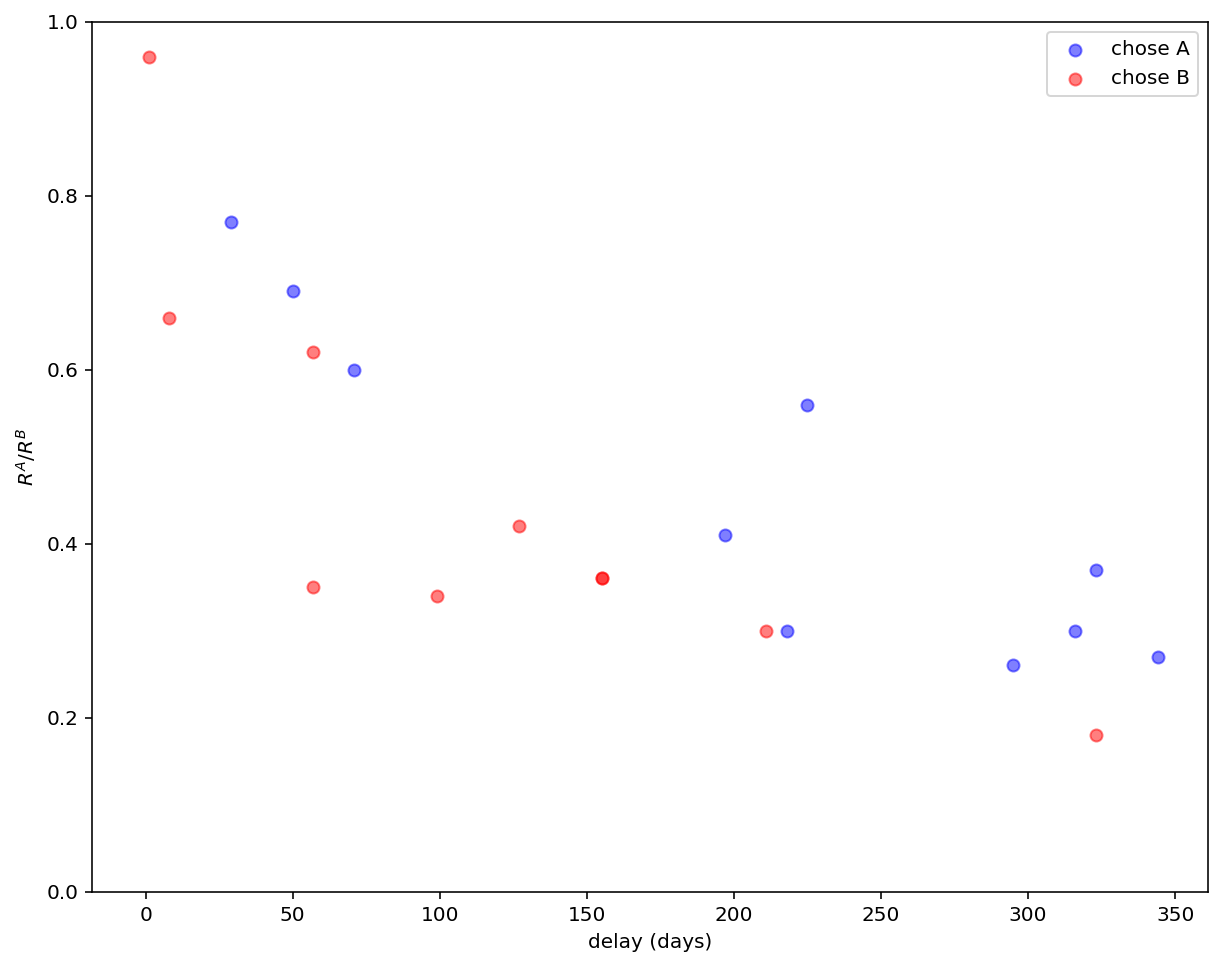

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

plot_delay_without_front_end_delays(ax, design_thing.all_data)
ax.set_ylim([0,1]);

Examine the parameter estimates for all of the fitted models

In [13]:
for model in fitted_models:
    print(f'model = {model.__class__.__name__}')
    display(model.get_θ_point_estimate())

model = Exponential


,k,α
0,0.00681,8.09149


model = Hyperbolic


,logk,α
0,-4.561652,1.131101


model = MyersonHyperboloid


,logk,s,α
0,-4.67032,1.108588,1.062373
